# Openclassrooms PJ7 : implement automatic image indexing

In [62]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import Perceptron
from sklearn import tree

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report

#from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score

import nltk
import codecs

from sklearn.decomposition import LatentDirichletAllocation

#from nltk.corpus.reader.api import CorpusReader
#from nltk.corpus.reader.api import CategorizedCorpusReader

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

#import pandas_profiling

from bs4 import BeautifulSoup

DATA_PATH = os.path.join("datasets", "stanforddogs")
DATA_PATH = os.path.join(DATA_PATH, "Images")

#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults_20190101-20200620.csv")
#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults 20200301-20200620_1.csv")

DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

# Set this to load (or train again / save) Clustering model to disk
SAVE_CLUSTERING_MODEL = False
CLUSTERING_FILE_MODEL_PREFIX = 'clustering_model'

SAVE_DESCRIPTORS = False
DESCRIPTORS_FILE_PREFIX = 'descriptors_file'


SAVE_BESTGRIDSEARCH_MODEL = False
LOAD_BESTGRIDSEARCH_MODEL = True
BESTGRIDSEARCH_FILE_MODEL_PREFIX = 'bestgridsearch_model_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
#from tqdm import tqdm_notebook as tqdm  #Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
from tqdm.notebook import tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk.cluster import KMeansClusterer # NLTK algorithm will be useful for cosine distance

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ7.pickle'


LEARNING_CURVE_STEP_SIZE = 100


# Image settings

In [2]:
from PIL import Image
from io import BytesIO

In [3]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()

# Exploration of 1 image from OC course

In [4]:
img = Image.open("simba.png") 

In [5]:
np_img = np.array(img)

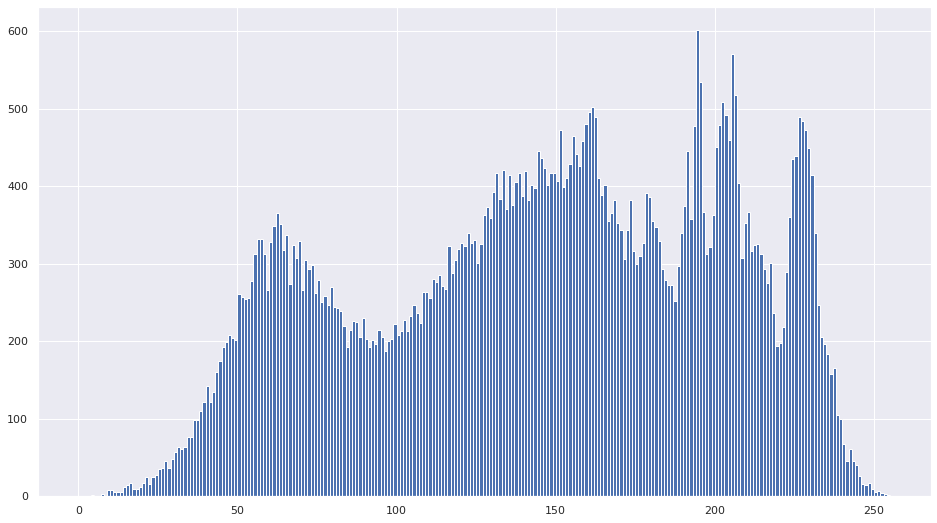

In [6]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img.flatten(), bins=range(256))
plt.show()

In [7]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img.flatten(), bins=range(256), edgecolor='blue')
plt.show()

In [8]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img.flatten(), bins=range(256), histtype='stepfilled')
plt.show()

# Exploration of 1 image

In [9]:
PATH_TESTIMAGE = DATA_PATH + "/n02111889-Samoyed/" + "n02111889_1363.jpg"
img = Image.open(PATH_TESTIMAGE) 

In [10]:
'n02108422-bull_mastiff'.split('-')[1]

'bull_mastiff'

In [11]:
display(img)

In [12]:
img.size

(500, 459)

In [13]:
img.mode

'RGB'

In [14]:
img.getpixel((20, 100))

(101, 95, 69)

In [15]:
np_image = np.array(img)

In [16]:
np_image.shape

(459, 500, 3)

In [17]:
np.array([1,2,3])

array([1, 2, 3])

In [18]:
np_img = np.array(img)

In [19]:
np_img[:, :, 0]

array([[205, 205, 205, ..., 189, 189, 189],
       [204, 204, 204, ..., 188, 188, 188],
       [203, 203, 203, ..., 188, 188, 188],
       ...,
       [ 49,  72,  74, ...,  63,  68,  78],
       [ 36,  62,  73, ...,  63,  65,  72],
       [ 51,  63,  65, ...,  62,  62,  64]], dtype=uint8)

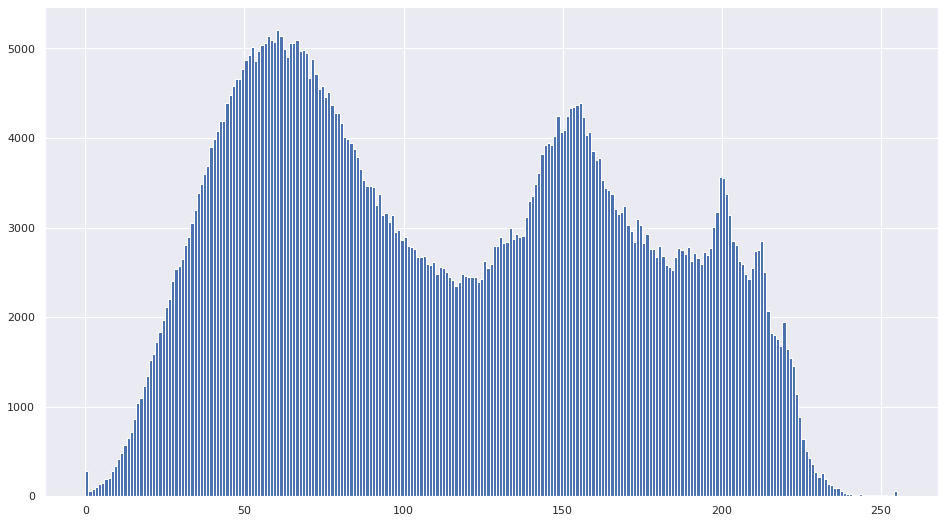

In [20]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img.flatten(), bins=range(256))
plt.show()

In [21]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img[:, :, 0].flatten(), bins=range(256))
plt.show()

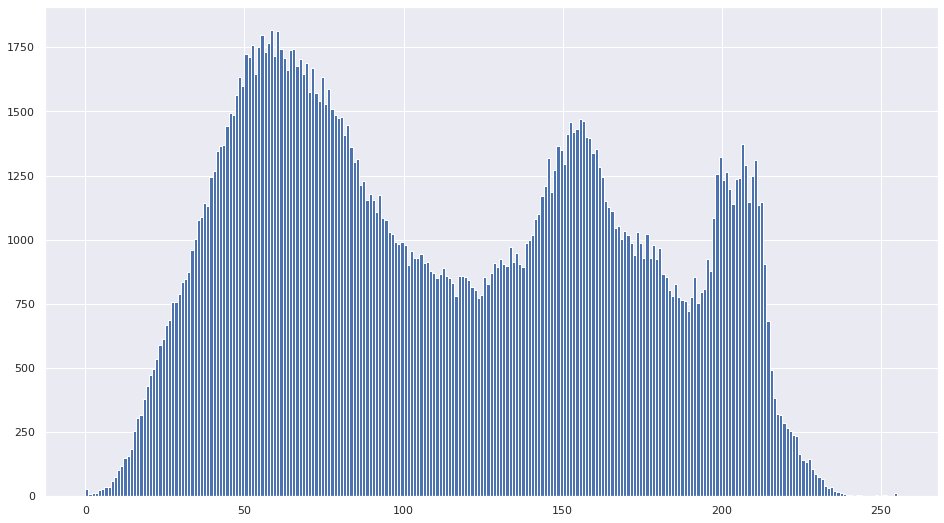

In [22]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img[:, :, 1].flatten(), bins=range(256))
plt.show()

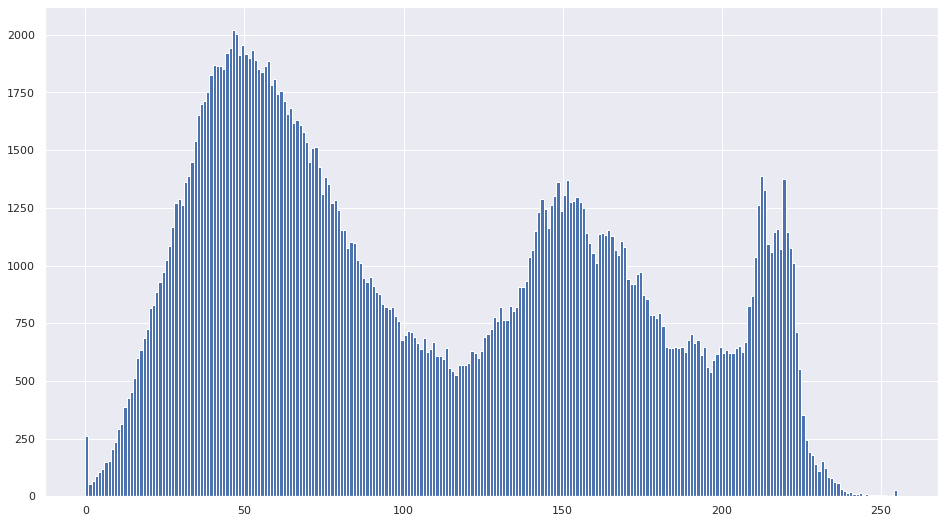

In [23]:
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

n, bins, patches = plt.hist(np_img[:, :, 2].flatten(), bins=range(256))
plt.show()

# Image preprocessing tests

In [24]:
imgcv = cv2.imread(PATH_TESTIMAGE)

In [25]:
imgcv_gray = cv2.cvtColor(imgcv,cv2.COLOR_BGR2GRAY) # Gray scaling

In [26]:
imgcv_gray.shape

(459, 500)

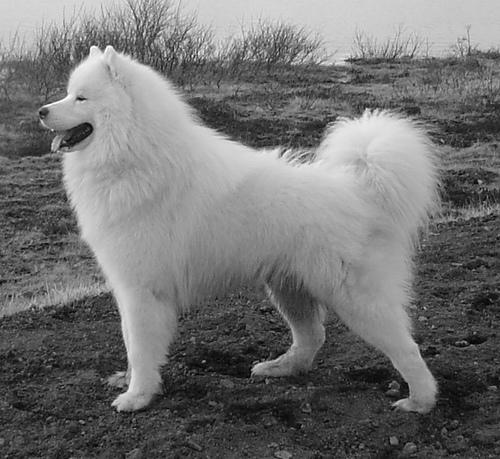

In [27]:
Image.fromarray(imgcv_gray)

In [28]:
kp = sift.detect(imgcv_gray,None)

imgcv_keypoints = cv2.drawKeypoints(imgcv_gray, kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, outImage=None)

cv2.imwrite('sift_keypoints.jpg',imgcv_keypoints)


True

In [29]:
Image.fromarray(imgcv_keypoints)

In [30]:
kp, des = sift.detectAndCompute(imgcv_gray,None)

In [31]:
len(kp)

1660

In [32]:
des.shape

(1660, 128)

In [33]:
kp_sorted = sorted(kp, key=lambda k : k.response, reverse=True)

In [34]:
imgcv_keypoints_best = cv2.drawKeypoints(imgcv_gray, kp_sorted[0:300], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, outImage=None)

cv2.imwrite('sift_keypoints_best.jpg',imgcv_keypoints_best)

True

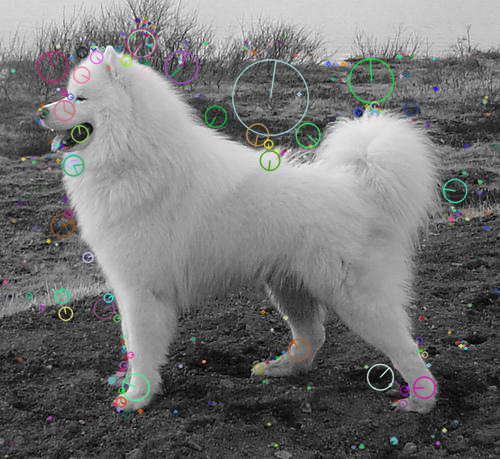

In [35]:
Image.fromarray(imgcv_keypoints_best)

In [36]:
kp_sorted[0:20]

[<KeyPoint 0x7fa22e4475a0>,
 <KeyPoint 0x7fa22e45ef90>,
 <KeyPoint 0x7fa22e443cc0>,
 <KeyPoint 0x7fa22e443cf0>,
 <KeyPoint 0x7fa22e451060>,
 <KeyPoint 0x7fa22e467e10>,
 <KeyPoint 0x7fa22e443420>,
 <KeyPoint 0x7fa22e443450>,
 <KeyPoint 0x7fa22e44ced0>,
 <KeyPoint 0x7fa22e656f90>,
 <KeyPoint 0x7fa22e4446c0>,
 <KeyPoint 0x7fa22e444fc0>,
 <KeyPoint 0x7fa22e443030>,
 <KeyPoint 0x7fa22e458e10>,
 <KeyPoint 0x7fa22e458e40>,
 <KeyPoint 0x7fa22e4439c0>,
 <KeyPoint 0x7fa22e4446f0>,
 <KeyPoint 0x7fa22e45e9f0>,
 <KeyPoint 0x7fa22e45ea20>,
 <KeyPoint 0x7fa22e44e7e0>]

In [114]:
kp[548]

<KeyPoint 0x7f4de4444870>

In [115]:
kp_sorted_indices = [i[0] for i in sorted(enumerate(kp), key=lambda x:x[1].response, reverse=True)]

In [116]:
kp_sorted_indices

[678,
 395,
 548,
 549,
 902,
 1563,
 502,
 503,
 811,
 37,
 432,
 480,
 481,
 1143,
 1144,
 532,
 433,
 365,
 366,
 858,
 205,
 500,
 323,
 324,
 542,
 543,
 1204,
 457,
 458,
 973,
 306,
 523,
 1281,
 284,
 1242,
 507,
 711,
 414,
 893,
 402,
 1056,
 199,
 494,
 495,
 223,
 565,
 566,
 809,
 439,
 1218,
 1186,
 1187,
 980,
 398,
 1225,
 1149,
 515,
 1267,
 19,
 1450,
 626,
 627,
 958,
 1246,
 271,
 1613,
 794,
 1315,
 461,
 361,
 362,
 971,
 972,
 1588,
 88,
 318,
 319,
 373,
 374,
 873,
 868,
 470,
 1195,
 1196,
 521,
 899,
 430,
 426,
 427,
 1258,
 392,
 773,
 506,
 550,
 551,
 875,
 547,
 202,
 504,
 554,
 555,
 262,
 1256,
 897,
 898,
 1105,
 610,
 611,
 1233,
 1282,
 857,
 1307,
 1308,
 1309,
 1141,
 291,
 1111,
 337,
 360,
 559,
 560,
 561,
 499,
 530,
 1091,
 1092,
 1093,
 336,
 1217,
 931,
 295,
 296,
 1650,
 1651,
 330,
 1547,
 1082,
 1439,
 519,
 612,
 613,
 969,
 1036,
 489,
 1122,
 1123,
 476,
 1202,
 1199,
 197,
 984,
 1231,
 101,
 780,
 525,
 526,
 261,
 1134,
 597,
 15

In [122]:
des[kp_sorted_indices[0:20], :].shape

(20, 128)

In [34]:
flann_params = dict(algorithm = 1, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {}) 
bow_extract = cv2.BOWImgDescriptorExtractor( sift , matcher )
#bow_extract.setVocabulary( vocab ) # the 64x20 dictionary, you made before # <= selon la doc:  Each row of the vocabulary is a visual word (cluster center). 

In [35]:
#bowsig = bow_extract.compute(imgcv_gray, kp)

# Load images and labels

In [90]:
filename_images = []
np_images = []
labels = []

deslist = []

NB_DOGS_PER_RACE = 5
i = 0

np_des = np.empty((0, 1+128), np.uint8)  # We add 1 column to store the image number

In [91]:
np_des

array([], shape=(0, 129), dtype=uint8)

In [92]:
np_toy = np.full((5, 10), 1, dtype=np.uint8)

In [93]:
np_toy.nbytes

50

In [94]:
%%time

cnt_files = sum([len(files) for r, d, files in os.walk(DATA_PATH)])
progbar = tqdm(range(cnt_files))

pic_number = 0
for root, dirs, files in os.walk(DATA_PATH):
    path = root.split(os.sep)
    
    i = 0    
    for file in files:
        if (i > NB_DOGS_PER_RACE - 1):
            break
        
        # Append filename to global list
        filename_images.append(os.path.join(root, file))
        
        img = cv2.imread(os.path.join(root, file))
        
        kp, des = sift.detectAndCompute(img, None)
        
        np_picnum = np.full((des.shape[0], 1), pic_number, dtype=np.uint16) # Add 1 column to store picture number
        des = np.hstack((np_picnum, des.astype(np.uint8)))
        
        #deslist.append(des)
        #np_des = np.append(np_des, des, axis=0)
        np_des = np.vstack((np_des, des)) # Equivalent of line above
        
        progbar.update(1)
        
        i += 1
        pic_number += 1

/home/francois/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 1min 48s, sys: 11.4 s, total: 2min
Wall time: 34.2 s


In [114]:
df_des = pd.DataFrame(np_des)

In [86]:
df_des.loc[:, 1].max()

227.0

In [89]:
df_des.max()

0      255.0
1      227.0
2      187.0
3      218.0
4      226.0
5      207.0
6      184.0
7      226.0
8      199.0
9      226.0
10     196.0
11     218.0
12     226.0
13     194.0
14     189.0
15     226.0
16     199.0
17     236.0
18     228.0
19     218.0
20     189.0
21     194.0
22     221.0
23     226.0
24     197.0
25     223.0
26     228.0
27     218.0
28     178.0
29     218.0
30     221.0
31     226.0
32     194.0
33     227.0
34     187.0
35     194.0
36     226.0
37     207.0
38     197.0
39     177.0
40     199.0
41     228.0
42     187.0
43     194.0
44     200.0
45     201.0
46     182.0
47     172.0
48     190.0
49     236.0
50     190.0
51     169.0
52     185.0
53     189.0
54     189.0
55     192.0
56     203.0
57     223.0
58     228.0
59     182.0
60     197.0
61     218.0
62     221.0
63     192.0
64     186.0
65     227.0
66     228.0
67     179.0
68     189.0
69     207.0
70     246.0
71     194.0
72     187.0
73     228.0
74     190.0
75     171.0
76     184.0

In [98]:
np_des.nbytes

148136118

In [ ]:
np_des = deslist[0]

for descriptor in deslist:
    np_des = np.vstack((np_des, descriptor))  

In [16]:
sys.getsizeof(np_images)

1256

In [22]:
np_images[100].nbytes

744000

In [23]:
np_images[100].dtype

dtype('uint8')

In [24]:
np_images[100].shape

(496, 500, 3)

In [32]:
np_images[50]

array([[[ 56,  81,  51],
        [ 70,  95,  63],
        [ 63,  89,  54],
        ...,
        [ 77,  92,  63],
        [104, 119,  90],
        [113, 126, 100]],

       [[ 30,  55,  25],
        [ 42,  67,  35],
        [ 35,  61,  26],
        ...,
        [ 85,  99,  73],
        [137, 150, 124],
        [164, 174, 149]],

       [[ 18,  43,  13],
        [ 28,  53,  23],
        [ 26,  51,  19],
        ...,
        [ 94, 104,  80],
        [158, 166, 145],
        [187, 195, 174]],

       ...,

       [[210, 234, 138],
        [205, 229, 133],
        [196, 220, 126],
        ...,
        [188, 217, 125],
        [169, 199, 103],
        [168, 199,  96]],

       [[195, 219, 123],
        [197, 221, 125],
        [200, 224, 130],
        ...,
        [181, 210, 118],
        [160, 190,  92],
        [162, 193,  89]],

       [[176, 200, 104],
        [183, 207, 111],
        [195, 219, 125],
        ...,
        [176, 205, 112],
        [154, 184,  84],
        [158, 190,  83]]

In [27]:
len(filename_images)

130

In [16]:
labels[50]

'bull_mastiff'

## With Pandas

In [53]:
from functions import *
importlib.reload(sys.modules['functions'])

<module 'functions' from '/home/francois/coding/OC/PJ7/functions.py'>

In [38]:
filename_images = []
np_images = []
labels = []

deslist = []

NB_DOGS_PER_RACE = 100 # Note: we have 120 dog races in the dataset
NB_KEYPOINTS_PER_DOG = 200
NB_CLUSTERS = 100
i = 0

df_des = pd.DataFrame(np.empty((0, 1+128), np.uint8), columns=['picnum'] +  [colname for colname in range(0,128)])  # We add 1 column to store the image number

In [39]:
df_des

Empty DataFrame
Columns: [picnum, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, ...]
Index: []

In [40]:
%%time

cnt_files = sum([len(files) for r, d, files in os.walk(DATA_PATH)])
progbar = tqdm(range(cnt_files))

pic_number = 0
for root, dirs, files in os.walk(DATA_PATH):
    path = root.split(os.sep)
    
    i = 0    
    for file in files:
        if (i > NB_DOGS_PER_RACE - 1):
            break
        
        # Append filename to global list
        filename_images.append(os.path.join(root, file))
        
        img = cv2.imread(os.path.join(root, file))
        
        kp, des = sift.detectAndCompute(img, None)
        
        kp_sorted_indices = [i[0] for i in sorted(enumerate(kp), key=lambda x:x[1].response, reverse=True)] # Sort by pixel importance descending
        des = des[kp_sorted_indices[0:NB_KEYPOINTS_PER_DOG], :]
        
        df_picnum = pd.DataFrame(np.full((des.shape[0], 1), pic_number, dtype=np.uint16), columns=['picnum']) # Add 1 column to store picture number
        #print(des.shape)
        #print(df_picnum.shape)
        
        df_des_1pic = pd.concat([df_picnum, pd.DataFrame(des.astype(np.uint8))], axis=1)
        #print(df_des_1pic.shape)
        #print(df_des_1pic.columns)
        
        #print('df_des.shape avant concat ')
        #print(df_des.shape)
        
        df_des = pd.concat([df_des, df_des_1pic], axis=0)

        #print('df_des.shape apres concat ')
        #print(df_des.shape)
        #print('!')
        
        progbar.update(1)
        
        i += 1
        pic_number += 1

/home/francois/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 44min 57s, sys: 5min 43s, total: 50min 40s
Wall time: 16min 56s


In [41]:
df_des

picnum   0   1   2   3   4   5   6   7    8    9  10  11   12  13  14  \
0         0   0   0   0  40  30  25   5   0    2    6  16  76   36  32  26   
1         0   0   0   2  16   2   2   1   1    0   10  51  79    2   0   0   
2         0   4  42  23  17  80  23   4   1   40   28   2  12  115  97  20   
3         0  38   4   2   3   9  14  11  40   25   37  25  20   17  15   8   
4         0   7  33  34   7   4   4   1   1    7   28  79  35    1   0   0   
..      ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ...  ..  ..   
195   11999  23   3   2   2   2   1  15  56  125   28   1   0    0   5  18   
196   11999  20  15   4   3   7   5   1   8   49  107  51   4    1   1   7   
197   11999  26  55  12  39  41   2   0   0  149  107   1   0    0   0   0   
198   11999  25  28  26  12   0   0   0   1  152   34   2   0    0   0   0   
199   11999   9   7  10   4   1   9   4   3   25   21   7   1    2   4  10   

     15   16   17  18  19  20   21  22  23   24  25  26  27  28   29  30   31  \
0     7   33   45  19   6   1    2  21  52   71  24   0   0   0    0   2   33   
1     0    8   76  66  13   0    2   1   0    6   9   1   0   0    1   0    3   
2     8   97  132   7   3   2    6  11  21   56  54   1   0   0    1  27   21   
3     4   68   79  16   1   0    0   0   5   24  16   5   0   0    0   5   15   
4     0    4    9  46  74   6    2   7   5    1   0   8  17   2    4  28    7   
..   ..  ...  ...  ..  ..  ..  ...  ..  ..  ...  ..  ..  ..  ..  ...  ..  ...   
195  99   36   22   8   4  88  125  24  22    0   0   0   1  64  125  64   31   
196  17  170  116  11   0   0    0   6  24  106   3   0   0   0    0   0   30   
197  13  107   18   4   0   0    0  15  55    0   1   1   0   0    0   4    5   
198  32  137   15   9   1   0    0   0  39   41  12   3   0   0    0   0   15   
199  18   66    4   1   0   0   15  37  88   19   0   0   0   0    7  64  130   

     32  33  34  35   36  37  38  39   40   41   42   43   44  45  46  47  \
0     0   0   0   7   49  44  18   2    7   21   64  133  133  68  23   5   
1     0   0  22  97   28   1   0   0   12   32   86  138  121  26  12  10   
2     5  12   7   6   36  71  22   2   13   14   12   66  132  68   7   3   
3    91  27   4  18   53  11   2  17   22   45   71   98  129  43   5   7   
4     5  36  69  35   40  13   2   2   12   43  127  126   58  25   9   8   
..   ..  ..  ..  ..  ...  ..  ..  ..  ...  ...  ...  ...  ...  ..  ..  ..   
195  44   1   0   0    2  14  16  73   45  104   25    3   16  26   6  14   
196   3   9   1   3   16   7   1   1   81   42    8    3    2   2   1   5   
197  66  24   7  25  100   5   3  15  149   49    0    0    0   0   0  47   
198  79  19  13  21    1   0   0   7  152   42    1    0    0   0   0  56   
199   3   5  17   8    1   8  30  20   43   44   15    1    0  18  71  20   

      48   49  50  51  52  53  54   55   56  57  58  59  60   61  62   63  \
0    133  133  84  47  13   7  13   40  100  13   0   0   0    0   1   28   
1    138  138  93  53   7   5  10   46   64  24   1   1   0    0   0    5   
2    132   60  15  26  19   9   5   59  111   5   0   0   0    0   0   55   
3    129  128  51  11   9   6   4   26   71   2   0   0   0    0   3   14   
4    127  121  95  34   4   5  19   55   34   2   0   2  32   33  36   19   
..   ...  ...  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ...  ..  ...   
195   80  125  47  10  37  44  17   22    8   1   1   8  60  125  99   21   
196  170   39   1   0   0   0   0   22  159   5   0   0   1    0   0   20   
197  142   48  10   0   0   0   1   12    0   2   3   0   0    0   0    0   
198  129   44  18   2   0   0   0   13   50  37  14   0   0    0   0    2   
199  130   26   2   0   0   1  23  105  130  15   0   0   0    0  20  130   

      64  65  66  67  68  69  70  71   72   73  74  75   76   77   78   79  \
0      1   0   0   2  37  26   3   2    8    5   5  31  133  133   83   17   
1      0   8  68  64  56  11   0   0   19   28  24  51  107  118  126   53   
2     40  3

In [42]:
#df_des.memory_usage()

In [43]:
df_des.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381580 entries, 0 to 199
Columns: 129 entries, picnum to 127
dtypes: uint16(1), uint8(128)
memory usage: 313.4 MB


In [44]:
clusterer = Clusterer(n_clusters=NB_CLUSTERS)

In [45]:
clusterer

Clusterer(n_clusters=100)

In [46]:
%time

if (SAVE_CLUSTERING_MODEL == True):
    clusterer.fit(df_des.iloc[:, 1:]) # We do this iloc in order not to include picnum column

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs
Fit method of Clusterer


/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.



Clusterer(n_clusters=100)

In [55]:
import functions
importlib.reload(sys.modules['functions'])

<module 'functions' from '/home/francois/coding/OC/PJ7/functions.py'>

In [57]:
if (SAVE_CLUSTERING_MODEL == True):
    with open(CLUSTERING_FILE_MODEL_PREFIX + 'model1' + '.pickle', 'wb') as f:
        pickle.dump(clusterer.clusterer, f, pickle.HIGHEST_PROTOCOL)

In [47]:
clusterer.clusterer

KMeans(n_clusters=100, n_jobs=1, random_state=42)

In [63]:
if (SAVE_DESCRIPTORS == True):
    with open(DESCRIPTORS_FILE_PREFIX + 'model1' + '.pickle', 'wb') as f:
        pickle.dump(df_des, f, pickle.HIGHEST_PROTOCOL)    

In [64]:
if (SAVE_CLUSTERING_MODEL == True):
    with open('filenames' + 'model1' + '.pickle', 'wb') as f:
        pickle.dump(filename_images, f, pickle.HIGHEST_PROTOCOL)

In [60]:
clusterer.predict(df_des.iloc[0:6, 1:])

Predict method of Clusterer


0    28
1    28
2    69
3    28
4    36
5    28
Name: 0, dtype: int32

In [61]:
df_des

picnum   0   1   2   3   4   5   6   7    8    9  10  11   12  13  14  \
0         0   0   0   0  40  30  25   5   0    2    6  16  76   36  32  26   
1         0   0   0   2  16   2   2   1   1    0   10  51  79    2   0   0   
2         0   4  42  23  17  80  23   4   1   40   28   2  12  115  97  20   
3         0  38   4   2   3   9  14  11  40   25   37  25  20   17  15   8   
4         0   7  33  34   7   4   4   1   1    7   28  79  35    1   0   0   
..      ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ...  ..  ..   
195   11999  23   3   2   2   2   1  15  56  125   28   1   0    0   5  18   
196   11999  20  15   4   3   7   5   1   8   49  107  51   4    1   1   7   
197   11999  26  55  12  39  41   2   0   0  149  107   1   0    0   0   0   
198   11999  25  28  26  12   0   0   0   1  152   34   2   0    0   0   0   
199   11999   9   7  10   4   1   9   4   3   25   21   7   1    2   4  10   

     15   16   17  18  19  20   21  22  23   24  25  26  27  28   29  30   31  \
0     7   33   45  19   6   1    2  21  52   71  24   0   0   0    0   2   33   
1     0    8   76  66  13   0    2   1   0    6   9   1   0   0    1   0    3   
2     8   97  132   7   3   2    6  11  21   56  54   1   0   0    1  27   21   
3     4   68   79  16   1   0    0   0   5   24  16   5   0   0    0   5   15   
4     0    4    9  46  74   6    2   7   5    1   0   8  17   2    4  28    7   
..   ..  ...  ...  ..  ..  ..  ...  ..  ..  ...  ..  ..  ..  ..  ...  ..  ...   
195  99   36   22   8   4  88  125  24  22    0   0   0   1  64  125  64   31   
196  17  170  116  11   0   0    0   6  24  106   3   0   0   0    0   0   30   
197  13  107   18   4   0   0    0  15  55    0   1   1   0   0    0   4    5   
198  32  137   15   9   1   0    0   0  39   41  12   3   0   0    0   0   15   
199  18   66    4   1   0   0   15  37  88   19   0   0   0   0    7  64  130   

     32  33  34  35   36  37  38  39   40   41   42   43   44  45  46  47  \
0     0   0   0   7   49  44  18   2    7   21   64  133  133  68  23   5   
1     0   0  22  97   28   1   0   0   12   32   86  138  121  26  12  10   
2     5  12   7   6   36  71  22   2   13   14   12   66  132  68   7   3   
3    91  27   4  18   53  11   2  17   22   45   71   98  129  43   5   7   
4     5  36  69  35   40  13   2   2   12   43  127  126   58  25   9   8   
..   ..  ..  ..  ..  ...  ..  ..  ..  ...  ...  ...  ...  ...  ..  ..  ..   
195  44   1   0   0    2  14  16  73   45  104   25    3   16  26   6  14   
196   3   9   1   3   16   7   1   1   81   42    8    3    2   2   1   5   
197  66  24   7  25  100   5   3  15  149   49    0    0    0   0   0  47   
198  79  19  13  21    1   0   0   7  152   42    1    0    0   0   0  56   
199   3   5  17   8    1   8  30  20   43   44   15    1    0  18  71  20   

      48   49  50  51  52  53  54   55   56  57  58  59  60   61  62   63  \
0    133  133  84  47  13   7  13   40  100  13   0   0   0    0   1   28   
1    138  138  93  53   7   5  10   46   64  24   1   1   0    0   0    5   
2    132   60  15  26  19   9   5   59  111   5   0   0   0    0   0   55   
3    129  128  51  11   9   6   4   26   71   2   0   0   0    0   3   14   
4    127  121  95  34   4   5  19   55   34   2   0   2  32   33  36   19   
..   ...  ...  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ...  ..  ...   
195   80  125  47  10  37  44  17   22    8   1   1   8  60  125  99   21   
196  170   39   1   0   0   0   0   22  159   5   0   0   1    0   0   20   
197  142   48  10   0   0   0   1   12    0   2   3   0   0    0   0    0   
198  129   44  18   2   0   0   0   13   50  37  14   0   0    0   0    2   
199  130   26   2   0   0   1  23  105  130  15   0   0   0    0  20  130   

      64  65  66  67  68  69  70  71   72   73  74  75   76   77   78   79  \
0      1   0   0   2  37  26   3   2    8    5   5  31  133  133   83   17   
1      0   8  68  64  56  11   0   0   19   28  24  51  107  118  126   53   
2     40  3

In [112]:
len(filename_images)

607

# Annex (old code)

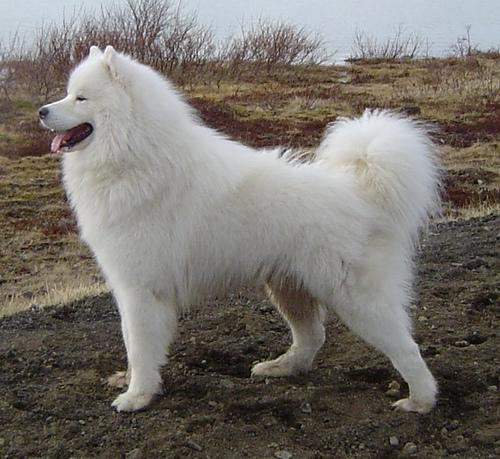

In [6]:
img = Image.open(DATA_PATH + "/n02111889-Samoyed/" + "n02111889_1363.jpg") 

temp = BytesIO()
img.save(temp, format="png")
display(Image.open(temp))

In [26]:
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(DATA_PATH):
    path = root.split(os.sep)
    #print((len(path) - 1) * 'p---', os.path.basename(root))
    
    for file in files:
        print(os.path.join(root, file))
        print(len(path) * '---', file)
        print(len(path) * '---', os.path.basename(root).split('-')[1])

datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_5260.jpg
------------ n02108422_5260.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_2203.jpg
------------ n02108422_2203.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_3235.jpg
------------ n02108422_3235.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_4396.jpg
------------ n02108422_4396.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_1096.jpg
------------ n02108422_1096.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_4064.jpg
------------ n02108422_4064.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_844.jpg
------------ n02108422_844.jpg
------------ bull_mastiff
datasets/stanforddogs/Images/n02108422-bull_mastiff/n02108422_2471.jpg
------------ n02108422_2471.

In [ ]:
for root, dirs, files in os.walk(DATA_PATH):
    path = root.split(os.sep)
    
    for file in files:
        # Append filename to global list
        filename_images.append(os.path.join(root, file))
        
        # Append image numpy array to global list
        im = Image.open(os.path.join(root, file))
        np_images.append(np.array(im))  # <= Takes too much memory (compared to jpeg disk space usage) : for later, either fix memory problem, or stream files from disk
        im.close()
        
        # Append image label to global list (we use the part of directory name after the '-'character as label)
        labels.append(os.path.basename(root).split('-')[1])

        # Limitation for now, because of memory
        '''
        i += 1
        
        if (i > 10):
            break
        '''
        